## Initialize notebook

In [63]:
import pandas as pd
import numpy as np
from time import time
from operator import itemgetter
from scipy.stats import randint, truncnorm, uniform

from sklearn import metrics, cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from ensemble import EnsembleClassifier

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 1.7 * matplotlib.rcParams['savefig.dpi']

## Load training data

In [39]:
# load X training data
X_train = np.array(pd.read_csv('X_train.csv', header=None))
# convert any NaNs to 0
X_train = np.nan_to_num(X_train)

# load Y training data
Y_train = np.array(pd.read_csv('Y_train.csv', header=None))
# re-shape array
Y_train = np.reshape(Y_train, (np.shape(Y_train)[0],))
# encode labels
le = LabelEncoder()
Y_train = le.fit_transform(Y_train)

print 'X_train shape: %i x %i' % (np.shape(X_train)[0], np.shape(X_train)[1])
print 'Y_train length: %i' % len(Y_train)

X_train shape: 108 x 40
Y_train length: 108


## Plot label frequency

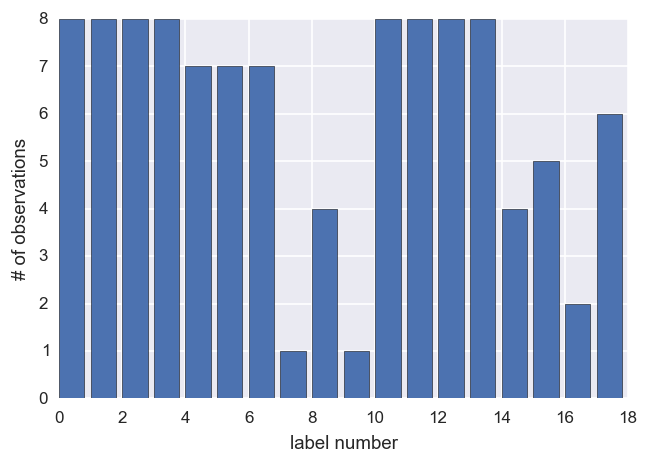

In [61]:
num_act = []
for n in np.unique(Y_train):
  num_act.append(len(np.where(Y_train == n)[0]))
  
plt.bar(np.unique(Y_train), num_act)
plt.xlabel('label number')
plt.ylabel('# of observations')

plt.savefig('label_frequency.eps', format='eps', dpi=1000)


## Randomized grid search (all features)

In [7]:
# Utility function to report best scores
def grid_search_report(grid_scores, n_top=3):
  top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
  for i, score in enumerate(top_scores):
    print('Model with rank: {0}'.format(i + 1))
    print('Mean validation score: {0:.3f} (std: {1:.3f})'.format(
          score.mean_validation_score,
          np.std(score.cv_validation_scores)))
    print('Parameters: {0}'.format(score.parameters))
    print('')
    

In [59]:
# params for grid search
n_iter_search = 100
cv = cross_validation.ShuffleSplit(len(Y_train), n_iter=5, test_size=0.2, random_state=42)

In [46]:
print 'GradientBoostingClassifier'

clf = GradientBoostingClassifier(random_state=42)
# specify parameters and distributions to sample from
param_dist = {'n_estimators': randint(25, 1000),
              'max_depth': randint(3, 11),
              'learning_rate': uniform(0.001, 0.3),
              'subsample': uniform(0.001, 0.99),
              'min_samples_split': randint(2, 10),
              'min_samples_leaf': randint(1, 10)}

# run randomized search
random_search_gb = RandomizedSearchCV(clf, param_distributions=param_dist,
                                      n_iter=n_iter_search, scoring='accuracy',
                                      n_jobs=4, cv=cv)

start = time()
random_search_gb.fit(X_train, Y_train)
print('RandomizedSearchCV took %.2f seconds for %d candidates'
      ' parameter settings.' % ((time() - start), n_iter_search))
grid_search_report(random_search_gb.grid_scores_)


GradientBoostingClassifier
RandomizedSearchCV took 704.26 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.736 (std: 0.034)
Parameters: {'learning_rate': 0.2228868874053661, 'min_samples_leaf': 8, 'n_estimators': 125, 'subsample': 0.4587928206235938, 'min_samples_split': 7, 'max_depth': 5}

Model with rank: 2
Mean validation score: 0.736 (std: 0.053)
Parameters: {'learning_rate': 0.08416556288967567, 'min_samples_leaf': 5, 'n_estimators': 696, 'subsample': 0.439058957758806, 'min_samples_split': 7, 'max_depth': 6}

Model with rank: 3
Mean validation score: 0.736 (std: 0.060)
Parameters: {'learning_rate': 0.1385342377341742, 'min_samples_leaf': 8, 'n_estimators': 342, 'subsample': 0.26128249064288955, 'min_samples_split': 6, 'max_depth': 7}



In [47]:
print 'RandomForestClassifier'

clf = RandomForestClassifier(n_jobs=-1, random_state=42)#, class_weight='balanced')
# specify parameters and distributions to sample from
param_dist = {'n_estimators': randint(25, 1000),
              'min_samples_split': randint(2, 10),
              'min_samples_leaf': randint(1, 10),
              'criterion': ['entropy', 'gini'],
              'max_features': ['sqrt', 'log2']}

# run randomized search
random_search_rf = RandomizedSearchCV(clf, param_distributions=param_dist,
                                      n_iter=n_iter_search, scoring='accuracy',
                                      n_jobs=4, cv=cv)

start = time()
random_search_rf.fit(X_train, Y_train)
print('RandomizedSearchCV took %.2f seconds for %d candidates'
      ' parameter settings.' % ((time() - start), n_iter_search))
grid_search_report(random_search_rf.grid_scores_)

RandomForestClassifier
RandomizedSearchCV took 240.39 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.764 (std: 0.045)
Parameters: {'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 2, 'criterion': 'entropy', 'n_estimators': 992}

Model with rank: 2
Mean validation score: 0.755 (std: 0.068)
Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'n_estimators': 205}

Model with rank: 3
Mean validation score: 0.755 (std: 0.062)
Parameters: {'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'entropy', 'n_estimators': 909}



In [40]:
print 'XGBClassifier'

clf = XGBClassifier(seed=42, nthread=-1, objective='multi:softprob')
# specify parameters and distributions to sample from
param_dist = {'n_estimators': randint(25, 1000),
              'max_depth': randint(3, 11),
              'learning_rate': uniform(0.001, 0.3),
              'subsample': uniform(0.001, 0.99),
              'colsample_bytree': uniform(0.2, 1)}

# run randomized search
random_search_xgb = RandomizedSearchCV(clf, param_distributions=param_dist,
                                      n_iter=n_iter_search, scoring='accuracy',
                                      n_jobs=4, cv=cv)

start = time()
random_search_xgb.fit(X_train, Y_train)
print('RandomizedSearchCV took %.2f seconds for %d candidates'
      ' parameter settings.' % ((time() - start), n_iter_search))
grid_search_report(random_search_xgb.grid_scores_)


XGBClassifier
RandomizedSearchCV took 61.65 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.791 (std: 0.022)
Parameters: {'n_estimators': 387, 'subsample': 0.7455139571476126, 'learning_rate': 0.048889499332886256, 'colsample_bytree': 0.258025987064968, 'max_depth': 4}

Model with rank: 2
Mean validation score: 0.782 (std: 0.034)
Parameters: {'n_estimators': 412, 'subsample': 0.7496377567343411, 'learning_rate': 0.09683144630440564, 'colsample_bytree': 0.5872470052075502, 'max_depth': 10}

Model with rank: 3
Mean validation score: 0.773 (std: 0.029)
Parameters: {'n_estimators': 100, 'subsample': 0.8232322311110469, 'learning_rate': 0.11246506490751534, 'colsample_bytree': 0.28148050181074397, 'max_depth': 10}



In [71]:
print 'ExtraTreesClassifier'

clf = ExtraTreesClassifier(n_jobs=-1, random_state=42)#, class_weight='balanced')
# specify parameters and distributions to sample from
param_dist = {'n_estimators': randint(25, 1000),
              'min_samples_split': randint(2, 10),
              'min_samples_leaf': randint(1, 10),
              'criterion': ['entropy', 'gini'],
              'max_features': ['sqrt', 'log2']}

# run randomized search
random_search_xt = RandomizedSearchCV(clf, param_distributions=param_dist,
                                      n_iter=n_iter_search, scoring='accuracy',
                                      n_jobs=4, cv=cv)

start = time()
random_search_xt.fit(X_train, Y_train)
print('RandomizedSearchCV took %.2f seconds for %d candidates'
      ' parameter settings.' % ((time() - start), n_iter_search))
grid_search_report(random_search_xt.grid_scores_)


ExtraTreesClassifier
RandomizedSearchCV took 218.14 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.800 (std: 0.036)
Parameters: {'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy', 'n_estimators': 683}

Model with rank: 2
Mean validation score: 0.791 (std: 0.074)
Parameters: {'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy', 'n_estimators': 365}

Model with rank: 3
Mean validation score: 0.791 (std: 0.074)
Parameters: {'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'gini', 'n_estimators': 288}



## Cross-validate (best models, using all features)


In [52]:
def compute_error(clf, X, y, n_iter=20):
  cv = cross_validation.ShuffleSplit(len(y), n_iter=n_iter, test_size=0.2, random_state=42)
  return cross_validation.cross_val_score(clf, X, y, cv=cv, scoring='accuracy').mean()

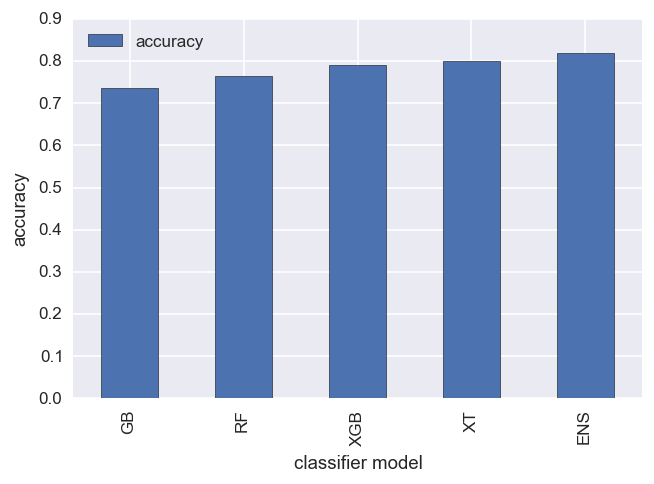

In [86]:
# best gradient boosting classifier
top_scores = sorted(random_search_gb.grid_scores_, key=itemgetter(1), reverse=True)
clf_gb = GradientBoostingClassifier(random_state=42, **top_scores[0].parameters)

# best random forest classifier
top_scores = sorted(random_search_rf.grid_scores_, key=itemgetter(1), reverse=True)
clf_rf = RandomForestClassifier(n_jobs=-1, random_state=42, **top_scores[0].parameters)

# best extreme gradient boosting classifier
top_scores = sorted(random_search_xgb.grid_scores_, key=itemgetter(1), reverse=True)
clf_xgb = XGBClassifier(nthread=-1, seed=42, **top_scores[0].parameters)

# best extra trees classifier
top_scores = sorted(random_search_xt.grid_scores_, key=itemgetter(1), reverse=True)
clf_xt = ExtraTreesClassifier(n_jobs=-1, random_state=42, **top_scores[0].parameters)

# ensemble classifier
clfs = [clf_gb, clf_rf, clf_xgb, clf_xt]
eclf = EnsembleClassifier(clfs=clfs, voting='soft')

model_performance = pd.DataFrame([
    ('GB', compute_error(clf_gb, X_train, Y_train, n_iter=5)),
    ('RF', compute_error(clf_rf, X_train, Y_train, n_iter=5)),
    ('XGB', compute_error(clf_xgb, X_train, Y_train, n_iter=5)),
    ('XT', compute_error(clf_xt, X_train, Y_train, n_iter=5)),
    ('ENS', compute_error(eclf, X_train, Y_train, n_iter=5)),
  ], columns=['classifier model', 'accuracy'])
# model_performance.set_index('Model')
model_performance.plot(x='classifier model', y='accuracy', kind='Bar')
plt.ylabel('accuracy')

plt.savefig('model_comparison.eps', format='eps', dpi=1000)

## Individual model comparison (extra trees model)

In [65]:
hand_idx = [0, 3, 4, 5, 12, 13, 14, 21, 22, 23]
chest_idx = [1, 6, 7, 8, 15, 16, 17, 24, 25, 26]
ankle_idx = [2, 9, 10, 11, 18, 19, 20, 27, 28, 29]
all_idx = [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]

In [70]:
clf = ExtraTreesClassifier(n_jobs=-1, random_state=42)#, class_weight='balanced')
# specify parameters and distributions to sample from
param_dist = {'n_estimators': randint(25, 1000),
              'min_samples_split': randint(2, 10),
              'min_samples_leaf': randint(1, 10),
              'criterion': ['entropy', 'gini'],
              'max_features': ['sqrt', 'log2']}

In [66]:
print 'Hand sensors only'
idx = hand_idx + all_idx

# run randomized search
random_search_hand = RandomizedSearchCV(clf, param_distributions=param_dist,
                                        n_iter=n_iter_search, scoring='accuracy',
                                        n_jobs=4, cv=cv)

start = time()
random_search_hand.fit(X_train[:, idx], Y_train)
print('RandomizedSearchCV took %.2f seconds for %d candidates'
      ' parameter settings.' % ((time() - start), n_iter_search))
grid_search_report(random_search_hand.grid_scores_)

Hand only
RandomizedSearchCV took 218.96 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.645 (std: 0.139)
Parameters: {'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'entropy', 'n_estimators': 535}

Model with rank: 2
Mean validation score: 0.645 (std: 0.101)
Parameters: {'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'gini', 'n_estimators': 357}

Model with rank: 3
Mean validation score: 0.636 (std: 0.129)
Parameters: {'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'entropy', 'n_estimators': 905}



In [67]:
print 'Chest sensors only'
idx = chest_idx + all_idx

# run randomized search
random_search_chest = RandomizedSearchCV(clf, param_distributions=param_dist,
                                        n_iter=n_iter_search, scoring='accuracy',
                                        n_jobs=4, cv=cv)

start = time()
random_search_chest.fit(X_train[:, idx], Y_train)
print('RandomizedSearchCV took %.2f seconds for %d candidates'
      ' parameter settings.' % ((time() - start), n_iter_search))
grid_search_report(random_search_chest.grid_scores_)

Chest sensors only
RandomizedSearchCV took 204.47 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.564 (std: 0.084)
Parameters: {'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'gini', 'n_estimators': 229}

Model with rank: 2
Mean validation score: 0.564 (std: 0.074)
Parameters: {'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'gini', 'n_estimators': 761}

Model with rank: 3
Mean validation score: 0.555 (std: 0.093)
Parameters: {'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'gini', 'n_estimators': 357}



In [68]:
print 'Ankle sensors only'
idx = ankle_idx + all_idx

# run randomized search
random_search_ankle = RandomizedSearchCV(clf, param_distributions=param_dist,
                                        n_iter=n_iter_search, scoring='accuracy',
                                        n_jobs=4, cv=cv)

start = time()
random_search_ankle.fit(X_train[:, idx], Y_train)
print('RandomizedSearchCV took %.2f seconds for %d candidates'
      ' parameter settings.' % ((time() - start), n_iter_search))
grid_search_report(random_search_ankle.grid_scores_)

Ankle sensors only
RandomizedSearchCV took 233.24 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.564 (std: 0.062)
Parameters: {'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'gini', 'n_estimators': 804}

Model with rank: 2
Mean validation score: 0.564 (std: 0.062)
Parameters: {'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'gini', 'n_estimators': 473}

Model with rank: 3
Mean validation score: 0.555 (std: 0.073)
Parameters: {'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'gini', 'n_estimators': 435}



In [73]:
print 'Hand + ankle sensors'
idx = hand_idx + ankle_idx + all_idx

# run randomized search
random_search_hand_ankle = RandomizedSearchCV(clf, param_distributions=param_dist,
                                        n_iter=n_iter_search, scoring='accuracy',
                                        n_jobs=4, cv=cv)

start = time()
random_search_hand_ankle.fit(X_train[:, idx], Y_train)
print('RandomizedSearchCV took %.2f seconds for %d candidates'
      ' parameter settings.' % ((time() - start), n_iter_search))
grid_search_report(random_search_hand_ankle.grid_scores_)

Hand + ankle sensors
RandomizedSearchCV took 206.30 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.845 (std: 0.062)
Parameters: {'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'entropy', 'n_estimators': 925}

Model with rank: 2
Mean validation score: 0.836 (std: 0.074)
Parameters: {'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy', 'n_estimators': 485}

Model with rank: 3
Mean validation score: 0.836 (std: 0.089)
Parameters: {'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'n_estimators': 810}



In [74]:
print 'Hand + chest sensors'
idx = hand_idx + chest_idx + all_idx

# run randomized search
random_search_hand_chest = RandomizedSearchCV(clf, param_distributions=param_dist,
                                        n_iter=n_iter_search, scoring='accuracy',
                                        n_jobs=4, cv=cv)

start = time()
random_search_hand_chest.fit(X_train[:, idx], Y_train)
print('RandomizedSearchCV took %.2f seconds for %d candidates'
      ' parameter settings.' % ((time() - start), n_iter_search))
grid_search_report(random_search_hand_chest.grid_scores_)

Hand + chest sensors
RandomizedSearchCV took 224.50 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.791 (std: 0.094)
Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'n_estimators': 803}

Model with rank: 2
Mean validation score: 0.791 (std: 0.055)
Parameters: {'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini', 'n_estimators': 899}

Model with rank: 3
Mean validation score: 0.782 (std: 0.078)
Parameters: {'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'entropy', 'n_estimators': 193}



In [75]:
print 'Chest + ankle sensors'
idx = chest_idx + ankle_idx + all_idx

# run randomized search
random_search_chest_ankle = RandomizedSearchCV(clf, param_distributions=param_dist,
                                        n_iter=n_iter_search, scoring='accuracy',
                                        n_jobs=4, cv=cv)

start = time()
random_search_chest_ankle.fit(X_train[:, idx], Y_train)
print('RandomizedSearchCV took %.2f seconds for %d candidates'
      ' parameter settings.' % ((time() - start), n_iter_search))
grid_search_report(random_search_chest_ankle.grid_scores_)

Chest + ankle sensors
RandomizedSearchCV took 232.38 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.655 (std: 0.036)
Parameters: {'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'gini', 'n_estimators': 569}

Model with rank: 2
Mean validation score: 0.645 (std: 0.034)
Parameters: {'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'gini', 'n_estimators': 835}

Model with rank: 3
Mean validation score: 0.627 (std: 0.053)
Parameters: {'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'entropy', 'n_estimators': 856}



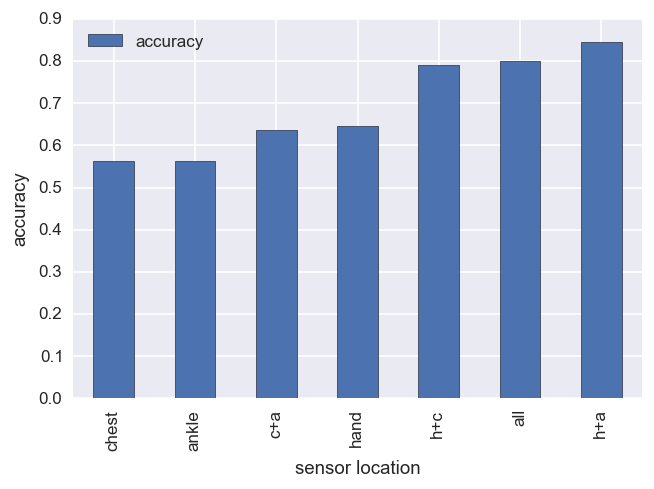

In [87]:
# chest only
top_scores = sorted(random_search_chest.grid_scores_, key=itemgetter(1), reverse=True)
clf_chest = ExtraTreesClassifier(n_jobs=-1, random_state=42, **top_scores[0].parameters)

# ankle only
top_scores = sorted(random_search_ankle.grid_scores_, key=itemgetter(1), reverse=True)
clf_ankle = ExtraTreesClassifier(n_jobs=-1, random_state=42, **top_scores[0].parameters)

# chest + ankle
top_scores = sorted(random_search_chest_ankle.grid_scores_, key=itemgetter(1), reverse=True)
clf_chest_ankle = ExtraTreesClassifier(n_jobs=-1, random_state=42, **top_scores[0].parameters)

# hand only
top_scores = sorted(random_search_hand.grid_scores_, key=itemgetter(1), reverse=True)
clf_hand = ExtraTreesClassifier(n_jobs=-1, random_state=42, **top_scores[0].parameters)

# hand + chest
top_scores = sorted(random_search_hand_chest.grid_scores_, key=itemgetter(1), reverse=True)
clf_hand_chest = ExtraTreesClassifier(n_jobs=-1, random_state=42, **top_scores[0].parameters)

# all features
top_scores = sorted(random_search_xt.grid_scores_, key=itemgetter(1), reverse=True)
clf_xt = ExtraTreesClassifier(n_jobs=-1, random_state=42, **top_scores[0].parameters)

# hand + ankle
top_scores = sorted(random_search_hand_ankle.grid_scores_, key=itemgetter(1), reverse=True)
clf_hand_ankle = ExtraTreesClassifier(n_jobs=-1, random_state=42, **top_scores[0].parameters)

model_performance = pd.DataFrame([
    ('chest', compute_error(clf_chest, X_train[:, chest_idx + all_idx], Y_train, n_iter=5)),
    ('ankle', compute_error(clf_ankle, X_train[:, ankle_idx + all_idx], Y_train, n_iter=5)),
    ('c+a', compute_error(clf_chest_ankle, X_train[:, ankle_idx + chest_idx + all_idx], Y_train, n_iter=5)),
    ('hand', compute_error(clf_hand, X_train[:, hand_idx + all_idx], Y_train, n_iter=5)),
    ('h+c', compute_error(clf_hand_chest, X_train[:, hand_idx + chest_idx + all_idx], Y_train, n_iter=5)),
    ('all', compute_error(clf_xt, X_train, Y_train, n_iter=5)),
    ('h+a', compute_error(clf_hand_ankle, X_train[:, hand_idx + ankle_idx + all_idx], Y_train, n_iter=5)),
  ], columns=['sensor location', 'accuracy'])
# model_performance.set_index('Location')
model_performance.plot(x='sensor location', y='accuracy', kind='Bar')
plt.ylabel('accuracy')

plt.savefig('location_comparison.eps', format='eps', dpi=1000)